In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.utils import shuffle
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from functools import reduce
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


pd.options.display.max_columns = None

# Step 3
# Working create Spark session 
# Initialize Spark session with the spark-excel library
# Stop any existing Spark session 
# "com.crealytics:spark-excel_2.12:0.13.5" was needed as other configs did not work with the version of Excel the files were supplied with.

fileName = "WA_Fn-UseC_-HR-Employee-Attrition.xlsx"
fileNameCSV = "WA_Fn-UseC_-HR-Employee-Attrition.csv"
sheet_name = 'WA_Fn-UseC_-HR-Employee-Attriti'
#df = pd.read_excel(fileName, header=0, sheet_name=sheet_name)
try:
    # Attempt to read the CSV file into a DataFrame
    df = pd.read_csv(fileNameCSV)
    print(df.head())
except PermissionError:
    print(f"PermissionError: You do not have permission to read the file '{fileNameCSV}'.")
except FileNotFoundError:
    print(f"FileNotFoundError: The file '{fileNameCSV}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")



   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

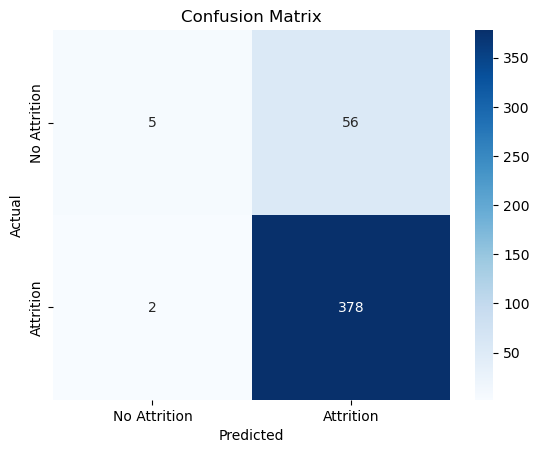

In [4]:


# Sample DataFrame


# Define the mapping dictionary
# Convert text labels to numerical values for the 'Attrition' column
df['Attrition'] = df['Attrition'].map({'Yes': 0, 'No': 1})
df['BusinessTravel'] = df['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
df['Department'] = df['Department'].map({ 'Sales': 0, 'Research & Development': 1, 'Human Resources': 2})
df['EducationField'] = df['EducationField'].map({ 'Life Sciences': 0, 'Other': 1, 'Human Resources': 2, 'Marketing': 3, 'Medical': 4, 'Technical Degree': 5})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['JobRole'] = df['JobRole'].map({ 'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8})
df['MaritalStatus'] = df['MaritalStatus'].map({'Single': 0, 'Married': 1, 'Divorced': 2})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['Over18'] = df['Over18'].map({'Y': 1, 'N': 0})

# Check for any missing values after mapping
print(df.isnull().sum())

# Handle any missing values
df = df.dropna()
# Verify that all features are numeric
print(df.dtypes)

# Save the DataFrame as a CSV file
df.to_csv("WholeDataAsNumbers.csv", index=False)
# Select Attrition, BusinessTravel, JobSatisfaction,  and WorkLifeBalance columns
selectedDF = df.iloc[:, [1, 2, 16, 29]]
selectedDF.to_csv("SelectedDataAsNumbers.csv", index=False)

#-------------------------------------------
#Below we are doing a correlation matrix to see which features are most correlated with the target variable
# Calculate the correlation matrix same as what we did in lab 5
corr_matrix = df.corr()

# Select features with high correlation to the target
corr_target = corr_matrix['Attrition'].abs().sort_values(ascending=False)
print(corr_target)


# Define features and target
X = df.drop(['Attrition'], axis=1)
y = df['Attrition']
#-------------------------------------------
# Below we are doing a Multiple Linear Regression
# Define the independent variables (features)
feauresDF = df[['BusinessTravel', 'JobSatisfaction', 'WorkLifeBalance']]

# Add a constant (intercept) to the model
feaures = sm.add_constant(feauresDF)

# Define the dependent variable (target)
target = df['Attrition']

# Fit the Multiple Linear Regression model
model = sm.OLS(target, feauresDF).fit()

# Display the model summary
print(model.summary())


#-------------------------------------------
#Below we are doign a confusion matrix to see how well the model is doing
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()